### Import module

In [7]:
import numpy as np
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [8]:
# Example usage of PushUpCounter function
model = YOLO('yolo11n-pose.pt')

In [ ]:
class PushUpCounter:
    def __init__(self, down_threshold=80, up_threshold=100, buffer_size=3, min_confidence=0.5, confidence_threshold=0.60):
        self.down_threshold = down_threshold
        self.up_threshold = up_threshold
        self.buffer_size = buffer_size
        self.min_confidence = min_confidence
        self.confidence_threshold = confidence_threshold
        
        # State variables
        self.current_state = "unknown"
        self.selected_arm = None
        self.angle_buffer = []
        self.count = 0
    
    def calculate_angle(self, shoulder_point, elbow_point, wrist_point):
        shoulder = np.array(shoulder_point)
        elbow = np.array(elbow_point)
        wrist = np.array(wrist_point)
        
        elbow_to_shoulder_vector = shoulder - elbow
        elbow_to_wrist_vector = wrist - elbow

        cos_angle = np.dot(elbow_to_shoulder_vector, elbow_to_wrist_vector) / (np.linalg.norm(elbow_to_shoulder_vector) * np.linalg.norm(elbow_to_wrist_vector))
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle = np.arccos(cos_angle)
        angle_degrees = np.degrees(angle)
        return angle_degrees
        
    def process_frame(self, results):
       
        if not results or not results[0].keypoints:
            return {
                'count': self.count,
                'state': self.current_state,
                'angle': None,
                'arm': 'NONE',
                'message': 'No keypoints detected'
            }
        is_confident = False
        confidences = results[0].keypoints.conf[0]
        keypoints = results[0].keypoints.xy[0]
        
        left_angle_hand = float('inf')
        right_angle_hand = float('inf')
        confidence_left_average = 0
        confidence_right_average = 0
        
        # Calculate left arm angle - only if all keypoints have confidence >= 60%
        if len(keypoints) > 9:
            left_shoulder_conf = confidences[5]
            left_elbow_conf = confidences[7]
            left_wrist_conf = confidences[9]
            
            # Check if ALL arm keypoints have confidence >= 60%
            if (left_shoulder_conf >= self.confidence_threshold and left_elbow_conf >= self.confidence_threshold and left_wrist_conf >= self.confidence_threshold):
                left_elbow_point = keypoints[7]
                left_shoulder_point = keypoints[5]
                left_wrist_point = keypoints[9]
                is_confident = True
                confidence_left_average = (left_shoulder_conf + left_elbow_conf + left_wrist_conf) / 3
                print(f'Left Shoulder: {left_shoulder_conf:.2f}, Elbow: {left_elbow_conf:.2f}, Wrist: {left_wrist_conf:.2f}')
                left_angle_hand = self.calculate_angle(left_shoulder_point, left_elbow_point, left_wrist_point)
            else:
                print(f'Left arm skipped - Low confidence: Shoulder: {left_shoulder_conf:.2f}, Elbow: {left_elbow_conf:.2f}, Wrist: {left_wrist_conf:.2f}')
        
        # Calculate right arm angle - only if all keypoints have confidence >= 60%
        if len(keypoints) > 10:
            right_shoulder_conf = confidences[6]
            right_elbow_conf = confidences[8]
            right_wrist_conf = confidences[10]
            # Check if ALL arm keypoints have confidence >= confidence_threshold
            if (right_shoulder_conf >= self.confidence_threshold and right_elbow_conf >= self.confidence_threshold and right_wrist_conf >= self.confidence_threshold):
                right_elbow_point = keypoints[8]
                right_shoulder_point = keypoints[6]
                right_wrist_point = keypoints[10]
                is_confident = True
                confidence_right_average = (right_shoulder_conf + right_elbow_conf + right_wrist_conf) / 3
                print(f'Right Shoulder: {right_shoulder_conf:.2f}, Elbow: {right_elbow_conf:.2f}, Wrist: {right_wrist_conf:.2f}')
                right_angle_hand = self.calculate_angle(right_shoulder_point, right_elbow_point, right_wrist_point)
            else:
                print(f'Right arm skipped - Low confidence: Shoulder: {right_shoulder_conf:.2f}, Elbow: {right_elbow_conf:.2f}, Wrist: {right_wrist_conf:.2f}')
        
        # Arm selection logic - choose once and stick with it
        if self.selected_arm is None:
            if (confidence_left_average > confidence_right_average and 
                left_angle_hand != float('inf')):
                self.selected_arm = "left"
            elif right_angle_hand != float('inf'):
                self.selected_arm = "right"
        
        # Get current angle from selected arm
        if self.selected_arm == "left" and left_angle_hand != float('inf'):
            raw_angle = left_angle_hand
            arm_label = "LEFT"
        elif self.selected_arm == "right" and right_angle_hand != float('inf'):
            raw_angle = right_angle_hand
            arm_label = "RIGHT"
        else:
            return {
                'count': self.count,
                'state': self.current_state,
                'angle': None,
                'arm': 'NONE',
                'message': 'Selected arm not available'
            }
        
        # Apply angle smoothing
        self.angle_buffer.append(raw_angle)
        if len(self.angle_buffer) > self.buffer_size:
            self.angle_buffer.pop(0)
        
        # Use smoothed angle (average of recent frames)
        smoothed_angle = sum(self.angle_buffer) / len(self.angle_buffer)
        
        # State machine with buffer zone (hysteresis)
        previous_state = self.current_state
        
        if is_confident:
            if smoothed_angle < self.down_threshold:
                # Clearly in down position
                if self.current_state == "up":
                    # Transition from up to down - complete push-up
                    self.count += 1
                self.current_state = "down"
            elif smoothed_angle > self.up_threshold:
                # Clearly in up position
                self.current_state = "up"
            # If angle is between thresholds, maintain current state (buffer zone)
        
        return {
            'count': self.count,
            'state': self.current_state,
            'previous_state': previous_state,
            'raw_angle': raw_angle,
            'smoothed_angle': smoothed_angle,
            'arm': arm_label,
            'is_confidence': is_confident
        }
    
    def reset(self):
        """Reset counter state"""
        self.current_state = "unknown"
        self.selected_arm = None
        self.angle_buffer = []
        self.count = 0

### Test Image

Left arm skipped - Low confidence: Shoulder: 0.97, Elbow: 0.64, Wrist: 0.51
Right arm skipped - Low confidence: Shoulder: 0.77, Elbow: 0.31, Wrist: 0.38
{'count': 0, 'state': 'unknown', 'angle': None, 'arm': 'NONE', 'message': 'Selected arm not available'}


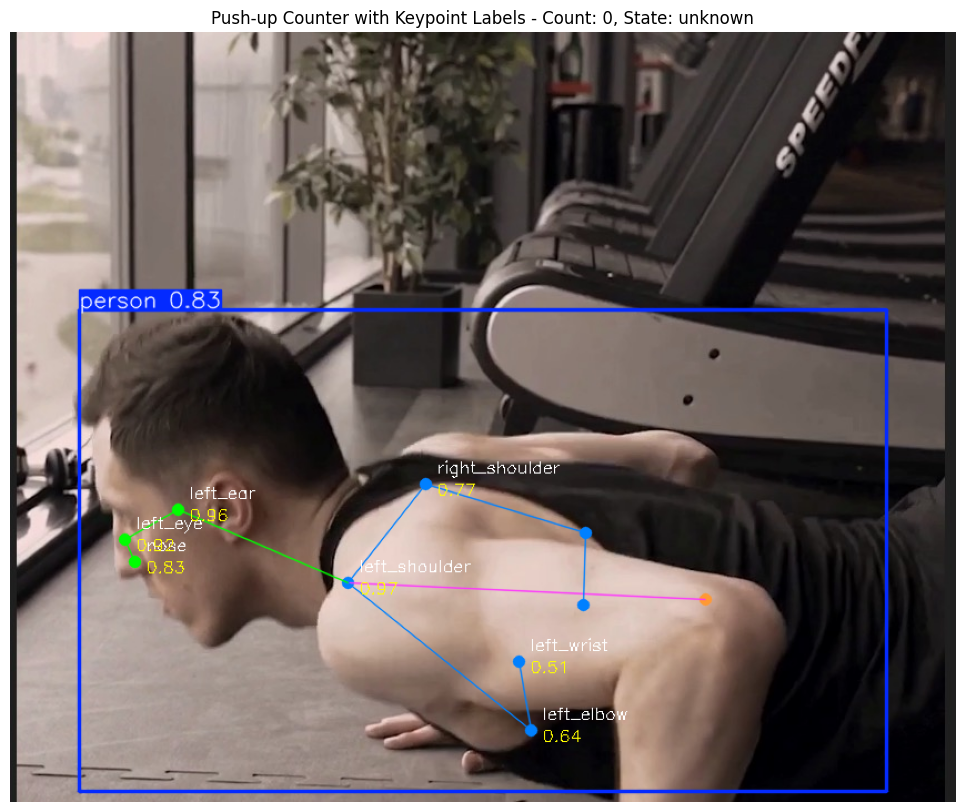

In [10]:
# Initialize the push-up counter
pushup_counter = PushUpCounter(
    down_threshold=80,    # < 80 degrees = down state
    up_threshold=100,     # > 100 degrees = up state
    buffer_size=3,        # Average of 3 frames for smoothing
    min_confidence=0.5    # Minimum keypoint confidence
)

# Predict on current frame
results = model.predict(source='0.png', show=False, verbose=False)

# Process frame with our function
result_info = pushup_counter.process_frame(results)
print(result_info)

# Get the annotated image
annotated_image = results[0].plot()

# Add custom keypoint labels
if results[0].keypoints is not None:
    keypoints = results[0].keypoints.xy[0]
    confidences = results[0].keypoints.conf[0]
    
    # Define keypoint names for YOLO pose (COCO format)
    keypoint_names = [
        "nose", "left_eye", "right_eye", "left_ear", "right_ear",
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
        "left_wrist", "right_wrist", "left_hip", "right_hip",
        "left_knee", "right_knee", "left_ankle", "right_ankle"
    ]
    
    # Add labels for keypoints with high confidence
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    
    for i, (keypoint, confidence, name) in enumerate(zip(keypoints, confidences, keypoint_names)):
        if confidence > 0.5:  # Only show if confidence is high
            x, y = int(keypoint[0]), int(keypoint[1])
            
            # Add keypoint name near the point
            cv2.putText(annotated_image, name, (x + 10, y - 10), 
                       font, font_scale, (255, 255, 255), thickness)
            
            # Add confidence score
            cv2.putText(annotated_image, f"{confidence:.2f}", (x + 10, y + 10), 
                       font, font_scale, (0, 255, 255), thickness)

# Add push-up counter info
if 'smoothed_angle' in result_info and result_info['smoothed_angle'] is not None:
    cv2.putText(annotated_image, f"Count: {result_info['count']}", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"State: {result_info['state']}", (10, 70), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(annotated_image, f"Angle: {result_info['smoothed_angle']:.1f}°", (10, 110), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    cv2.putText(annotated_image, f"Tracking: {result_info['arm']} arm", (10, 150), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

# Display the image using matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Push-up Counter with Keypoint Labels - Count: {result_info['count']}, State: {result_info['state']}")
plt.show()

### Test 

In [11]:


# # Initialize the push-up counter
# pushup_counter = PushUpCounter(
#     down_threshold=80,    # < 80 degrees = down state
#     up_threshold=100,     # > 100 degrees = up state
#     buffer_size=3,        # Average of 3 frames for smoothing
#     min_confidence=0.5    # Minimum keypoint confidence
# )

# # Open video file
# cap = cv2.VideoCapture('push1.mp4')
# frame_count = 0

# while cap.isOpened():
#     ret, frame = cap.read()
#     frame_count += 1
#     if not ret:
#         break
    
#     # Predict on current frame
#     results = model.predict(source=frame, show=False, verbose=False)
    
#     # Process frame with our function
#     result_info = pushup_counter.process_frame(results)

#     # Display frame
#     if results and results[0].keypoints is not None:
#         annotated_frame = results[0].plot()
#     else:
#         annotated_frame = frame
    
#     cv2.imshow('Push-up Counter', annotated_frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# print('Total Frames Processed:', frame_count)
# cap.release()
# cv2.destroyAllWindows()
# print('Total Push-ups:', pushup_counter.count)

### Real-time Camera Push-up Counter

In [12]:
# Real-time Camera Push-up Counter
model = YOLO('yolo11n-pose.pt')

# Initialize the push-up counter
pushup_counter = PushUpCounter(
    down_threshold=80,    # < 80 degrees = down state
    up_threshold=100,     # > 100 degrees = up state
    buffer_size=3,        # Average of 3 frames for smoothing
    min_confidence=0.5    # Minimum keypoint confidence
)

# Open camera (0 is usually the default camera)
cap = cv2.VideoCapture(0)

# Set camera properties (optional)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

print("Starting real-time push-up counter...")
print("Position yourself so your full body is visible in the frame")
print("Press 'q' to quit, 'r' to reset counter")

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame from camera")
        break
    
    frame_count += 1
    
    # Flip frame horizontally for mirror effect (more natural)
    frame = cv2.flip(frame, 1)
    
    # Predict on current frame
    results = model.predict(source=frame, show=False, verbose=False)
    
    # Process frame with our function
    result_info = pushup_counter.process_frame(results)
    
    # Create display frame
    if results and results[0].keypoints is not None:
        annotated_frame = results[0].plot()
        # Flip the annotated frame too
        annotated_frame = cv2.flip(annotated_frame, 1)
    else:
        annotated_frame = frame
    
    # Add counter information to the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    
    # Display push-up count
    count_text = f"Push-ups: {result_info['count']}"
    cv2.putText(annotated_frame, count_text, (10, 40), font, font_scale, (0, 255, 0), thickness)
    
    # Display current state
    if 'state' in result_info:
        state_text = f"State: {result_info['state']}"
        cv2.putText(annotated_frame, state_text, (10, 80), font, 0.7, (255, 255, 0), 2)
    if 'is_confidence' in result_info:
        confidence_text = f"Confidence: {'Yes' if result_info['is_confidence'] else 'No'}"
        cv2.putText(annotated_frame, confidence_text, (10, 100), font, 0.7, (255, 0, 0), 2)
    # Display current angle if available
    if 'raw_angle' in result_info and result_info['raw_angle'] is not None:
        angle_text = f"Raw Angle: {result_info['raw_angle']:.1f}°"
        cv2.putText(annotated_frame, angle_text, (10, 120), font, 0.7, (0, 255, 255), 2)
        
        # Display which arm is being tracked
        if 'arm' in result_info:
            arm_text = f"Tracking: {result_info['arm']} arm"
            cv2.putText(annotated_frame, arm_text, (10, 160), font, 0.7, (255, 0, 255), 2)
    
    # Display instructions
    cv2.putText(annotated_frame, "Press 'q' to quit, 'r' to reset", (10, annotated_frame.shape[0] - 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Show the frame
    cv2.imshow('Real-time Push-up Counter', annotated_frame)
    
    # Handle key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        # Reset counter
        pushup_counter.reset()
        print(f"Counter reset at frame {frame_count}")
    
    # Print push-up completion (optional - can be commented out to reduce console output)
    if 'smoothed_angle' in result_info and result_info['smoothed_angle'] is not None:
        if result_info['state'] == 'down' and result_info.get('previous_state') == 'up':
            print(f"Push-up #{result_info['count']} completed! (angle: {result_info['smoothed_angle']:.1f}°)")

print(f"Session ended. Total frames processed: {frame_count}")
print(f"Total push-ups completed: {pushup_counter.count}")

# Release resources
cap.release()
cv2.destroyAllWindows()

Starting real-time push-up counter...
Position yourself so your full body is visible in the frame
Press 'q' to quit, 'r' to reset counter
Left arm skipped - Low confidence: Shoulder: 0.76, Elbow: 0.18, Wrist: 0.07
Right arm skipped - Low confidence: Shoulder: 0.92, Elbow: 0.62, Wrist: 0.25
Left arm skipped - Low confidence: Shoulder: 0.81, Elbow: 0.27, Wrist: 0.09
Right arm skipped - Low confidence: Shoulder: 0.90, Elbow: 0.60, Wrist: 0.22
Left arm skipped - Low confidence: Shoulder: 0.86, Elbow: 0.35, Wrist: 0.13
Right arm skipped - Low confidence: Shoulder: 0.89, Elbow: 0.54, Wrist: 0.21
Left arm skipped - Low confidence: Shoulder: 0.59, Elbow: 0.04, Wrist: 0.15
Right arm skipped - Low confidence: Shoulder: 0.68, Elbow: 0.06, Wrist: 0.19
Left arm skipped - Low confidence: Shoulder: 0.62, Elbow: 0.04, Wrist: 0.15
Right arm skipped - Low confidence: Shoulder: 0.68, Elbow: 0.06, Wrist: 0.18
Left arm skipped - Low confidence: Shoulder: 0.61, Elbow: 0.05, Wrist: 0.15
Right arm skipped - L

/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_16043/786125257.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  shoulder = np.array(shoulder_point)
/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_16043/786125257.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  elbow = np.array(elbow_point)
/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_16043/786125257.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword

Left arm skipped - Low confidence: Shoulder: 0.73, Elbow: 0.15, Wrist: 0.07
Right arm skipped - Low confidence: Shoulder: 0.94, Elbow: 0.77, Wrist: 0.38
Left arm skipped - Low confidence: Shoulder: 0.94, Elbow: 0.52, Wrist: 0.56
Right arm skipped - Low confidence: Shoulder: 0.94, Elbow: 0.47, Wrist: 0.56
Left Shoulder: 0.97, Elbow: 0.76, Wrist: 0.70
Right arm skipped - Low confidence: Shoulder: 0.97, Elbow: 0.66, Wrist: 0.62
Left arm skipped - Low confidence: Shoulder: 0.57, Elbow: 0.15, Wrist: 0.12
Right Shoulder: 0.98, Elbow: 0.98, Wrist: 0.87
Left arm skipped - Low confidence: Shoulder: 0.66, Elbow: 0.27, Wrist: 0.25
Right Shoulder: 0.97, Elbow: 0.97, Wrist: 0.87
Left arm skipped - Low confidence: Shoulder: 0.59, Elbow: 0.40, Wrist: 0.51
Right Shoulder: 0.97, Elbow: 0.98, Wrist: 0.95
Left Shoulder: 0.99, Elbow: 0.93, Wrist: 0.82
Right Shoulder: 1.00, Elbow: 0.93, Wrist: 0.77
Left arm skipped - Low confidence: Shoulder: 0.71, Elbow: 0.24, Wrist: 0.08
Right arm skipped - Low confidenc

KeyboardInterrupt: 